In [237]:
import pyarrow.feather as feather
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import numpy as np
import requests
import os
import concurrent.futures
import multiprocessing
import tensorflow as tf

In [238]:
df = feather.read_feather('data/artsy_full.feather')

In [239]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27577 entries, 0 to 27576
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    27577 non-null  object 
 1   slug                  27577 non-null  object 
 2   title                 27576 non-null  object 
 3   category              27576 non-null  object 
 4   medium                27575 non-null  object 
 5   date                  27577 non-null  object 
 6   iconicity             27577 non-null  float64
 7   sold                  27577 non-null  bool   
 8   image_versions        27469 non-null  object 
 9   dimensions_height_in  14120 non-null  float64
 10  dimensions_width_in   13607 non-null  float64
 11  dimensions_depth_in   836 non-null    float64
 12  permalink             27577 non-null  object 
 13  api_link              27577 non-null  object 
 14  thumb_link            26482 non-null  object 
 15  image_link         

In [240]:
df.dropna(subset=['image_versions'], inplace=True)

In [241]:
def convert_to_list(value):
    value = value.tolist()
    
    return value

def get_largest_version(row):
    
    image_versions = row['image_versions']
    
    if 'large' in image_versions:
        version = 'large'
    elif 'medium' in image_versions:
        version = 'medium'
    else:
        version = image_versions[0]
    
    row['main_image_version'] = version
    
    return row
    
df['image_versions'] = df['image_versions'].apply(convert_to_list)
df = df.apply(get_largest_version, axis=1)

In [245]:
df.category.unique()

array(['Painting', 'Sculpture', 'Drawing, Collage or other Work on Paper',
       'Photography', 'Design/Decorative Art', 'Print', 'Mixed Media',
       'Architecture', 'Textile Arts', 'Posters', 'Other', None,
       'Books and Portfolios', '', 'Fashion Design and Wearable Art',
       'Jewelry'], dtype=object)

In [247]:
df = df[df['category'] == 'Painting']

In [248]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer

transform = PowerTransformer()

X = df.drop(columns=['iconicity'])
y = transform.fit_transform(df[['iconicity']])


X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [286]:
df['iconicity'].describe()

count    2349.000000
mean       37.037656
std        44.836938
min        12.449186
25%        14.114769
50%        30.507436
75%        36.125105
max       756.280585
Name: iconicity, dtype: float64

In [289]:
(df['iconicity'] > 36).sum() / len(df)

0.25202213707960835

(array([688., 359., 961., 146.,  81.,  25.,  67.,  16.,   1.,   5.]),
 array([2.5216552 , 2.93233093, 3.34300665, 3.75368238, 4.1643581 ,
        4.57503383, 4.98570955, 5.39638528, 5.807061  , 6.21773673,
        6.62841245]),
 <BarContainer object of 10 artists>)

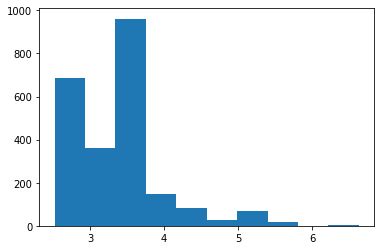

In [285]:
plt.hist(np.log(df['iconicity']))

In [249]:
X_train.reset_index(inplace=True)
# y_train.reset_index(inplace=True, drop=True)
X_val.reset_index(inplace=True)
# y_val.reset_index(inplace=True, drop=True)

In [262]:
class ImageDownloader:
    
    def __init__(self):
        pass
        
    def download(self, df, subset_string):
        self.df = df
        self.subset_string = subset_string
        self.bad_link = []
        
        try:
            path = './images'
            os.mkdir(path)
        except:
            pass
        try:
            os.mkdir(path+'/'+subset_string)
        except:
            pass
        try:
            os.mkdir(path+'/'+subset_string+'/0')
        except:
            pass
        
        
        self.image_dir = path+'/'+subset_string

        max_threads = 15
        threads = min(max_threads, len(df))

        indexes = df.index

        with concurrent.futures.ThreadPoolExecutor(max_workers=threads) as executor:
            executor.map(self._download_imgs_for_set, indexes)
            
        return self
            
    def _download_imgs_for_set(self, index):

        row = self.df.iloc[index]
        filename = f'{str(index).zfill(5)}.jpg'
        path = f'images/{self.subset_string}/0/{filename}'

        img_data = requests.get(row.image_link.replace('{image_version}', row.main_image_version))
        if img_data.ok:
            with open(path, 'wb') as handler:
                handler.write(img_data.content)
        else:
            self.bad_link.append(index)
        
        
            
            

In [263]:
train_downloader = ImageDownloader()
train_downloader.download(X_train, 'train')
val_downloader = ImageDownloader()
val_downloader.download(X_val, 'val')

In [264]:
train_downloader.image_dir

'./images/train'

In [265]:
len(os.listdir('./images/train/0'))

1879

In [266]:
len(y_train)

1879

In [267]:
batch_size = 128
img_width = 224
img_height = 224

train_ds = tf.keras.utils.image_dataset_from_directory(directory=train_downloader.image_dir,
                                                       labels=list(y_train), validation_split=0.2,
                                                       subset='training',
                                                       seed=42,
                                                       image_size=(img_height, img_width),
                                                       batch_size=batch_size,
                                                      shuffle=False)

val_ds = tf.keras.utils.image_dataset_from_directory(directory=val_downloader.image_dir,
                                                     labels=list(y_val), validation_split=0.2,
                                                     subset='validation',
                                                     seed=42,
                                                     image_size=(img_height, img_width),
                                                     batch_size=batch_size,
                                                    shuffle=False)

Found 1879 files belonging to 1 classes.
Using 1504 files for training.
Found 470 files belonging to 1 classes.
Using 94 files for validation.


In [268]:
for elem in train_ds.take(1):
    test = elem

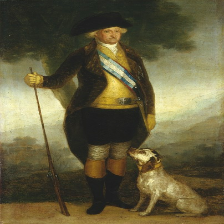

In [269]:
tf.keras.utils.array_to_img(test[0][0])

In [270]:
test[1][0]

<tf.Tensor: shape=(1,), dtype=float64, numpy=array([-1.38707276])>

In [271]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE).repeat()
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE).repeat()

In [272]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten

In [273]:


model = Sequential([
    Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"),
    MaxPool2D(pool_size=(2,2),strides=(2,2)),
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPool2D(pool_size=(2,2),strides=(2,2)),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPool2D(pool_size=(2,2),strides=(2,2)),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPool2D(pool_size=(2,2),strides=(2,2)),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPool2D(pool_size=(2,2),strides=(2,2)),
    Flatten(),
    Dense(units=4096,activation="relu"),
    Dense(units=4096,activation="relu"),
    Dense(units=1)
])

model_simple = Sequential([
    Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"),
    MaxPool2D(pool_size=(2,2),strides=(2,2)),
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPool2D(pool_size=(2,2),strides=(2,2)),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPool2D(pool_size=(2,2),strides=(2,2)),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPool2D(pool_size=(2,2),strides=(2,2)),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPool2D(pool_size=(2,2),strides=(2,2)),
    Flatten(),
    Dense(units=4096,activation="relu"),
    Dense(units=1)
])

In [274]:
import warnings
warnings.filterwarnings("ignore")

In [275]:
steps_per_epoch = 1504//batch_size

validation_steps = 94//batch_size
print(steps_per_epoch)

11


In [276]:
validation_steps

0

In [277]:

from tensorflow.keras.optimizers import Adam
opt = Adam(lr=0.001)
model_simple.compile(optimizer=opt, loss='mean_absolute_error', metrics=['mse'])

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_mse', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq=137)
early = EarlyStopping(monitor='val_mse', min_delta=0, patience=20, verbose=1, mode='auto')
history = model_simple.fit(train_ds.repeat(), steps_per_epoch=steps_per_epoch, epochs=50, validation_data=val_ds, validation_steps=validation_steps, callbacks=[early, checkpoint])

Epoch 1/50


2022-08-02 17:50:59.312764: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 21s 2s/step - loss: 957.7009 - mse: 10155302.0000
Epoch 2/50
11/11 [==============================] - 16s 2s/step - loss: 0.8014 - mse: 1.0390
Epoch 3/50
11/11 [==============================] - 16s 1s/step - loss: 0.7910 - mse: 1.0129
Epoch 4/50
11/11 [==============================] - 16s 1s/step - loss: 0.7614 - mse: 0.9974
Epoch 5/50
11/11 [==============================] - 16s 1s/step - loss: 0.7636 - mse: 1.0138
Epoch 6/50
11/11 [==============================] - 16s 2s/step - loss: 0.7695 - mse: 1.0180
Epoch 7/50
11/11 [==============================] - 16s 1s/step - loss: 0.7424 - mse: 0.9653
Epoch 8/50
11/11 [==============================] - 16s 1s/step - loss: 0.7527 - mse: 0.9861
Epoch 9/50
11/11 [==============================] - 16s 1s/step - loss: 0.7440 - mse: 0.9639
Epoch 10/50
11/11 [==============================] - 16s 1s/step - loss: 0.7552 - mse: 0.9544
Epoch 11/50
11/11 [==============================] - 16s 1s/step - loss

Epoch 28/50
11/11 [==============================] - 16s 1s/step - loss: 0.4614 - mse: 0.4231
Epoch 29/50
11/11 [==============================] - 16s 1s/step - loss: 0.4440 - mse: 0.3994
Epoch 30/50
11/11 [==============================] - 16s 1s/step - loss: 0.4691 - mse: 0.4328
Epoch 31/50
11/11 [==============================] - 16s 1s/step - loss: 0.4688 - mse: 0.4315
Epoch 32/50
11/11 [==============================] - 16s 1s/step - loss: 0.4614 - mse: 0.4228
Epoch 33/50
11/11 [==============================] - 16s 1s/step - loss: 0.4696 - mse: 0.4220
Epoch 34/50
11/11 [==============================] - 16s 1s/step - loss: 0.4201 - mse: 0.3611
Epoch 35/50
11/11 [==============================] - 16s 1s/step - loss: 0.4444 - mse: 0.3715
Epoch 36/50
11/11 [==============================] - 16s 1s/step - loss: 0.4202 - mse: 0.3565
Epoch 37/50
11/11 [==============================] - 16s 1s/step - loss: 0.3759 - mse: 0.3061
Epoch 38/50
11/11 [==============================] - 16s 1s/

In [278]:
from keras.preprocessing import image
import matplotlib.pyplot as plt

img = image.load_img("./images/train/0/10583.jpg",target_size=(224,224))
img = np.asarray(img)
plt.imshow(img)
img = np.expand_dims(img, axis=0)
transform.inverse_transform(model.predict(img))

FileNotFoundError: [Errno 2] No such file or directory: './images/train/0/10583.jpg'

In [280]:
transform.inverse_transform(model.predict(train_ds.take(1)))

2022-08-02 18:05:01.211575: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


array([[22.344706],
       [21.018358],
       [16.208502],
       [20.84974 ],
       [21.792196],
       [23.445452],
       [19.339102],
       [19.703161],
       [17.681871],
       [19.168802],
       [19.072767],
       [22.903133],
       [23.119665],
       [21.389414],
       [20.794537],
       [20.9201  ],
       [19.913818],
       [18.958721],
       [25.061611],
       [21.836166],
       [23.08285 ],
       [23.348923],
       [22.03713 ],
       [19.786135],
       [21.639399],
       [22.036087],
       [18.739473],
       [21.045334],
       [18.809973],
       [17.992035],
       [22.386972],
       [18.627735],
       [19.86895 ],
       [24.839293],
       [22.453434],
       [20.010674],
       [24.580265],
       [22.386454],
       [23.570402],
       [17.08325 ],
       [21.539742],
       [19.101175],
       [19.117718],
       [23.505608],
       [25.721235],
       [21.945242],
       [17.986942],
       [20.788452],
       [21.841705],
       [22.182573],


In [282]:
transform.inverse_transform(test[0][1])

array([[ 13.58317049],
       [ 31.28961761],
       [ 14.03191982],
       [ 23.55282245],
       [180.46039274],
       [ 43.45703332],
       [ 35.62918589],
       [ 13.47202892],
       [ 13.76417463],
       [ 33.70241329],
       [ 31.91179762],
       [ 30.32912579],
       [ 32.80239   ],
       [ 13.51316425],
       [ 30.57363177],
       [ 37.79122324],
       [ 32.67322782],
       [ 34.66806635],
       [ 37.55104317],
       [ 29.59484868],
       [ 36.84048278],
       [ 40.67675991],
       [ 14.00720451],
       [ 39.73511777],
       [ 45.11802633],
       [ 37.9531482 ],
       [ 34.4868765 ],
       [ 24.30440702],
       [ 46.80302696],
       [ 32.19686422],
       [ 13.77433738],
       [ 25.34282021],
       [ 41.25486785],
       [ 30.50743648],
       [ 38.35552184],
       [203.07631648],
       [ 32.7167543 ],
       [ 31.28479688],
       [ 33.18474827],
       [ 48.0037374 ],
       [247.17346354],
       [ 43.23691641],
       [ 30.33453344],
       [ 13

In [281]:
test = [elem for elem in train_ds.take(1)]
transform.inverse_transform(test[0][1]) - transform.inverse_transform(model.predict(train_ds.take(1)))

array([[ -8.7615351 ],
       [ 10.27125938],
       [ -2.176582  ],
       [  2.70308338],
       [158.66819647],
       [ 20.01158158],
       [ 16.29008409],
       [ -6.23113232],
       [ -3.91769679],
       [ 14.53361103],
       [ 12.83903036],
       [  7.4259924 ],
       [  9.68272485],
       [ -7.87624958],
       [  9.77909518],
       [ 16.87112398],
       [ 12.75940946],
       [ 15.70934519],
       [ 12.48943199],
       [  7.7586823 ],
       [ 13.75763328],
       [ 17.32783718],
       [ -8.02992585],
       [ 19.94898305],
       [ 23.47862775],
       [ 15.91706117],
       [ 15.74740316],
       [  3.25907316],
       [ 27.9930542 ],
       [ 14.20482931],
       [ -8.61263504],
       [  6.71508507],
       [ 21.38591796],
       [  5.66814395],
       [ 15.90208785],
       [183.06564295],
       [  8.13648925],
       [  8.89834325],
       [  9.61434612],
       [ 30.92048736],
       [225.63372203],
       [ 24.1357411 ],
       [ 11.2168157 ],
       [ -9